Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### **Importing Skin Cancer Data**

### **Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_dir_train = pathlib.Path("gdrive/MyDrive/cnn/images/Train/")
data_dir_test = pathlib.Path('gdrive/MyDrive/cnn/images/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

# **Create a dataset**

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


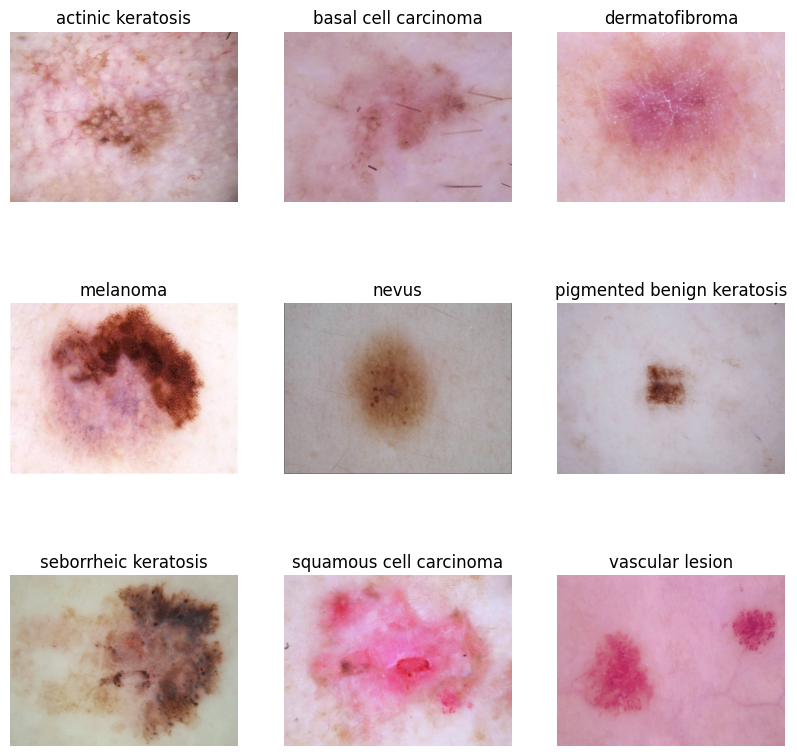

In [9]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(128, kernel_size=(3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [12]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        3

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 654s 2s/step - loss: 2.0145 - accuracy: 0.2338 - val_loss: 1.8867 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.7991 - accuracy: 0.3594 - val_loss: 1.6515 - val_accuracy: 0.3848 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6014 - accuracy: 0.4275 - val_loss: 1.7497 - val_accuracy: 0.3736 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5051 - accuracy: 0.4821 - val_loss: 1.5313 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4136 - accuracy: 0.4994 - val_loss: 1.4741 - val_accuracy: 0.4698 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3245 - accuracy: 0.5290 - val_loss: 1.4611 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2

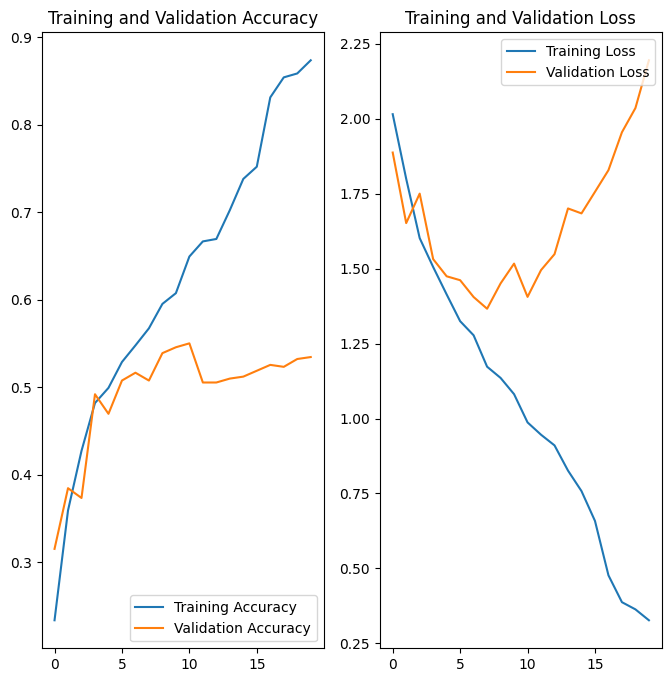

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

# **Write your findings here**

1.   As the training accuracy increases linearly over time, where as the validation accuracy stall at 50% accuracy in training process.

2.   The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around 50% accuracy on the validation set.
3. The difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting.



**Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting**

In [16]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

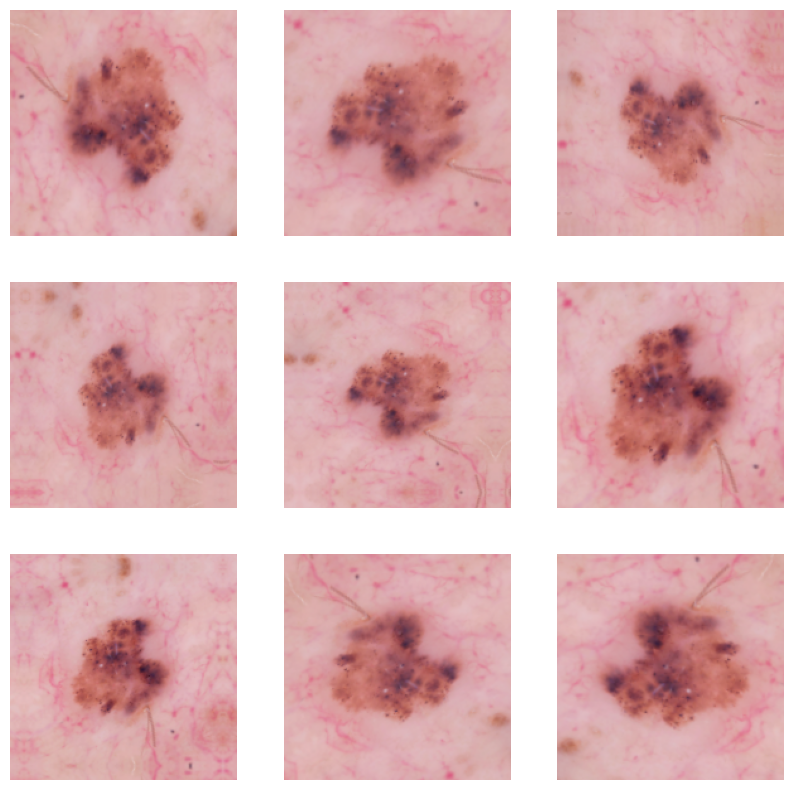

In [17]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Create the model, compile and train the model**

In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

## **Compiling the model**

In [19]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

## **Training the model**

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 9s 70ms/step - loss: 2.0771 - accuracy: 0.1931 - val_loss: 2.0509 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 2.0210 - accuracy: 0.1953 - val_loss: 2.0285 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 2.0044 - accuracy: 0.2182 - val_loss: 1.9681 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.8859 - accuracy: 0.2779 - val_loss: 1.8125 - val_accuracy: 0.2975 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.7772 - accuracy: 0.3114 - val_loss: 1.6657 - val_accuracy: 0.3758 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.7859 - accuracy: 0.2963 - val_loss: 1.8340 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 4s 63ms/step - loss: 1.7

## **Visualizing the results**

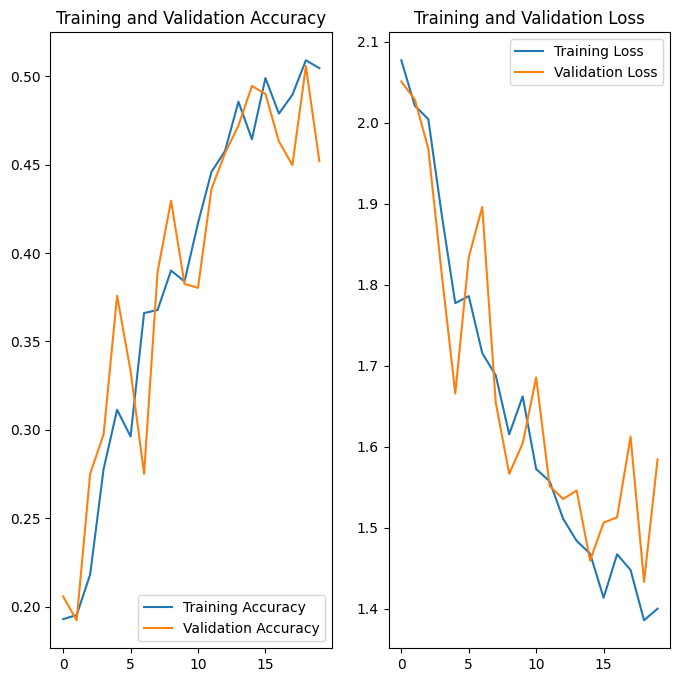

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

***Findings***

1.   The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.

**Find the distribution of classes in the training dataset.**

**Context:** **Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.**

In [23]:
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

<ipython-input-23-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-23-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-23-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-23-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipy

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

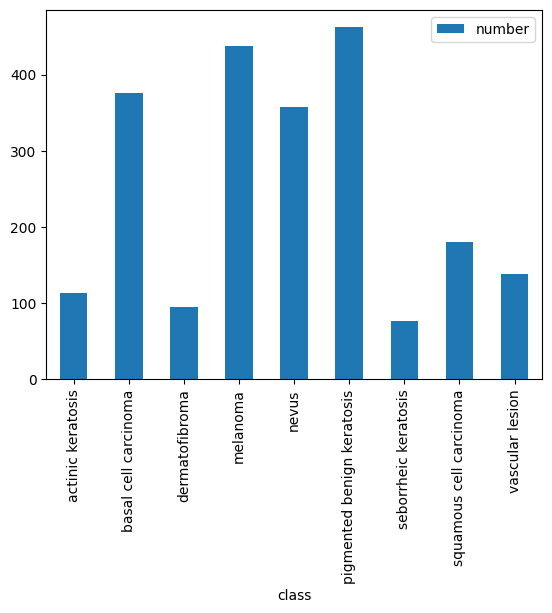

In [24]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

# **Findings**

Which class has the least number of samples?
  - seborrheic keratosis(77)

Which classes dominate the data in terms proportionate number of samples?
   - pigmented benign keratosis (462)

  

**Rectify the class imbalance**

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

In [26]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [27]:
path_to_training_dataset="gdrive/MyDrive/cnn/images/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E66742EF880>: 100%|██████████| 500/500 [00:28<00:00, 17.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E667430FB50>: 100%|██████████| 500/500 [00:29<00:00, 16.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6717E64B20>: 100%|██████████| 500/500 [00:25<00:00, 19.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E67002D2C80>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6714130C10>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E66756A45E0>: 100%|██████████| 500/500 [00:23<00:00, 21.17 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E67002D0EB0>: 100%|██████████| 500/500 [00:57<00:00,  8.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6700138190>: 100%|██████████| 500/500 [00:20<00:00, 23.96 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/cnn/images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6675750400>: 100%|██████████| 500/500 [00:23<00:00, 21.11 Samples/s]


In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [29]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

['gdrive/MyDrive/cnn/images/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0034135.jpg_b69f9312-facc-48bb-84bf-7cf44a8a7608.jpg',
 'gdrive/MyDrive/cnn/images/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028926.jpg_07b68806-11d9-4180-a1ba-0c9a4c93e80c.jpg',
 'gdrive/MyDrive/cnn/images/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032138.jpg_50e1f9f9-f0b4-436c-a0f9-4bb224186f91.jpg',
 'gdrive/MyDrive/cnn/images/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_504f5a2c-fccd-4642-b023-5e59bb29ead5.jpg',
 'gdrive/MyDrive/cnn/images/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033626.jpg_cc6e5533-3f53-483c-a3ca-0f2af7d72b0d.jpg',
 'gdrive/MyDrive/cnn/images/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027008.jpg_4ff6e570-dd63-40e7-a61d-3420d7defd7b.jpg',
 'gdrive/MyDrive/cnn/images/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_feb4889e-04ad-4bb5-977e-0e1da2c21e98.jpg',
 'gdrive/MyDrive/cnn

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
for i in class_names:
    directory ='gdrive/MyDrive/cnn/images/Train'
    directory_out ='gdrive/MyDrive/cnn/images/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


**Train the model on the data created using Augmentor**

In [35]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [36]:
data_dir_train="gdrive/MyDrive/cnn/images/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create your model (make sure to include normalization)**

In [38]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

**Compile your model (Choose optimizer and loss function appropriately)**

In [39]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 41, 41, 128)      

**Train your model**

In [41]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/30
169/169 [==============================] - 43s 217ms/step - loss: 2.1955 - accuracy: 0.1313 - val_loss: 2.1862 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 41s 235ms/step - loss: 2.1451 - accuracy: 0.1532 - val_loss: 2.0439 - val_accuracy: 0.2160 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 38s 216ms/step - loss: 2.0332 - accuracy: 0.2057 - val_loss: 1.9296 - val_accuracy: 0.2383 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 41s 234ms/step - loss: 1.9011 - accuracy: 0.2552 - val_loss: 1.7748 - val_accuracy: 0.2932 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 41s 236ms/step - loss: 1.7060 - accuracy: 0.3327 - val_loss: 1.5307 - val_accuracy: 0.4083 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 41s 234ms/step - loss: 1.5366 - accuracy: 0.3954 - val_loss: 1.4542 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

**Visualize the model results**

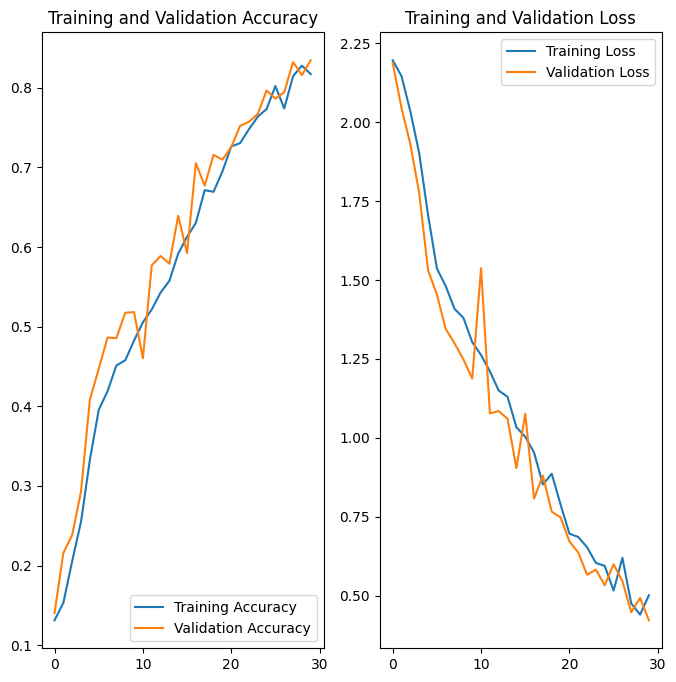

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

# **Findings**

- The training accuracy and validation accuracy are almost same. This is a sign of good fit.
- The training loss and validation loss are almost same. This is a sign of good fit.
- The Validation accuracy is 0.81 which is good. The model is able to classify the images with 81% accuracy.